<a href="https://colab.research.google.com/github/r44yan/majhus/blob/main/LungScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
import PIL as Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot  as plt
from sklearn.model_selection  import train_test_split , cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib import pyplot
import itertools
import struct
from array import array
from os.path  import join
%matplotlib inline

import tensorflow  as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam ,Adamax ,AdamW
from tensorflow.keras import regularizers

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier


import random

random.seed(42)


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedemajid","key":"f7942a19c891f566ec72f96c0f7828b2"}'}

In [ ]:
!kaggle config set -n api_key -v f7942a19c891f566ec72f96c0f7828b2

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! cp kaggle.json ~/.kaggle/ #copys file into directory

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [01:17<00:00, 28.1MB/s]
100% 1.76G/1.76G [01:17<00:00, 24.4MB/s]


In [ ]:
!unzip /content/lung-and-colon-cancer-histopathological-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [ ]:
data_directory = "/content/lung_colon_image_set"
filepaths = []
labels = []
folds=os.listdir(data_directory)
for fold in folds:
    foldpath= os.path.join(data_directory, fold)
    flist=os.listdir(foldpath)
    for f in flist:
        f_path=os.path.join(foldpath, f)
        filelist=os.listdir(f_path)
        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)
            if f=="colon_aca" :
                labels.append("Colon Adenocarcinoma")
            elif f == "colon_n":
                labels.append("Colon Benign Tissue")
            elif f=="lung_aca":
                labels.append("Lung Adenocarcinoma")
            elif f == "lung_n":
                labels.append("Lung Benign Tissue")
            elif f=="lung_scc":
                labels.append("Lung Squamous Cell Carcinoma")

Fseries= pd.Series(filepaths ,name= "file_paths")
Lseries =pd.Series(labels ,name ="Labels")
df= pd.concat ([Fseries ,Lseries],axis =1)
df

,file_paths,Labels
0,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
1,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
2,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
3,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
4,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
...,...,...
24995,/content/lung_colon_image_set/lung_image_sets/...,Lung Benign Tissue
24996,/content/lung_colon_image_set/lung_image_sets/...,Lung Benign Tissue
24997,/content/lung_colon_image_set/lung_image_sets/...,Lung Benign Tissue
24998,/content/lung_colon_image_set/lung_image_sets/...,Lung Benign Tissue


In [ ]:
#Split data into train 80%
train , dummy = train_test_split(df , train_size = 0.8 , shuffle = True ,
                                 random_state= 42 , stratify= df['Labels'])
#Split data into validation and test 10% both
valid , test = train_test_split(dummy , train_size = 0.5 , shuffle = True ,
                                random_state= 42 , stratify= dummy['Labels'])

In [ ]:
print(df.columns)

Index(['file_paths', 'Labels'], dtype='object')


In [ ]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

img_size = (64 , 64)
img_shape = (64, 64, 3)
channels = 3
class_count = 5

train_gen = tr_gen.flow_from_dataframe(train , x_col = 'file_paths' , y_col = 'Labels' ,target_size = img_size ,
                                       class_mode= 'categorical',color_mode = 'rgb' , shuffle= True , batch_size= 64)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'file_paths' , y_col = 'Labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = True , batch_size= 64)
test_gen = ts_gen.flow_from_dataframe(test , x_col = 'file_paths' , y_col = 'Labels' , target_size = img_size ,
                                     class_mode = 'categorical' , color_mode = 'rgb' , shuffle= False , batch_size = 64)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


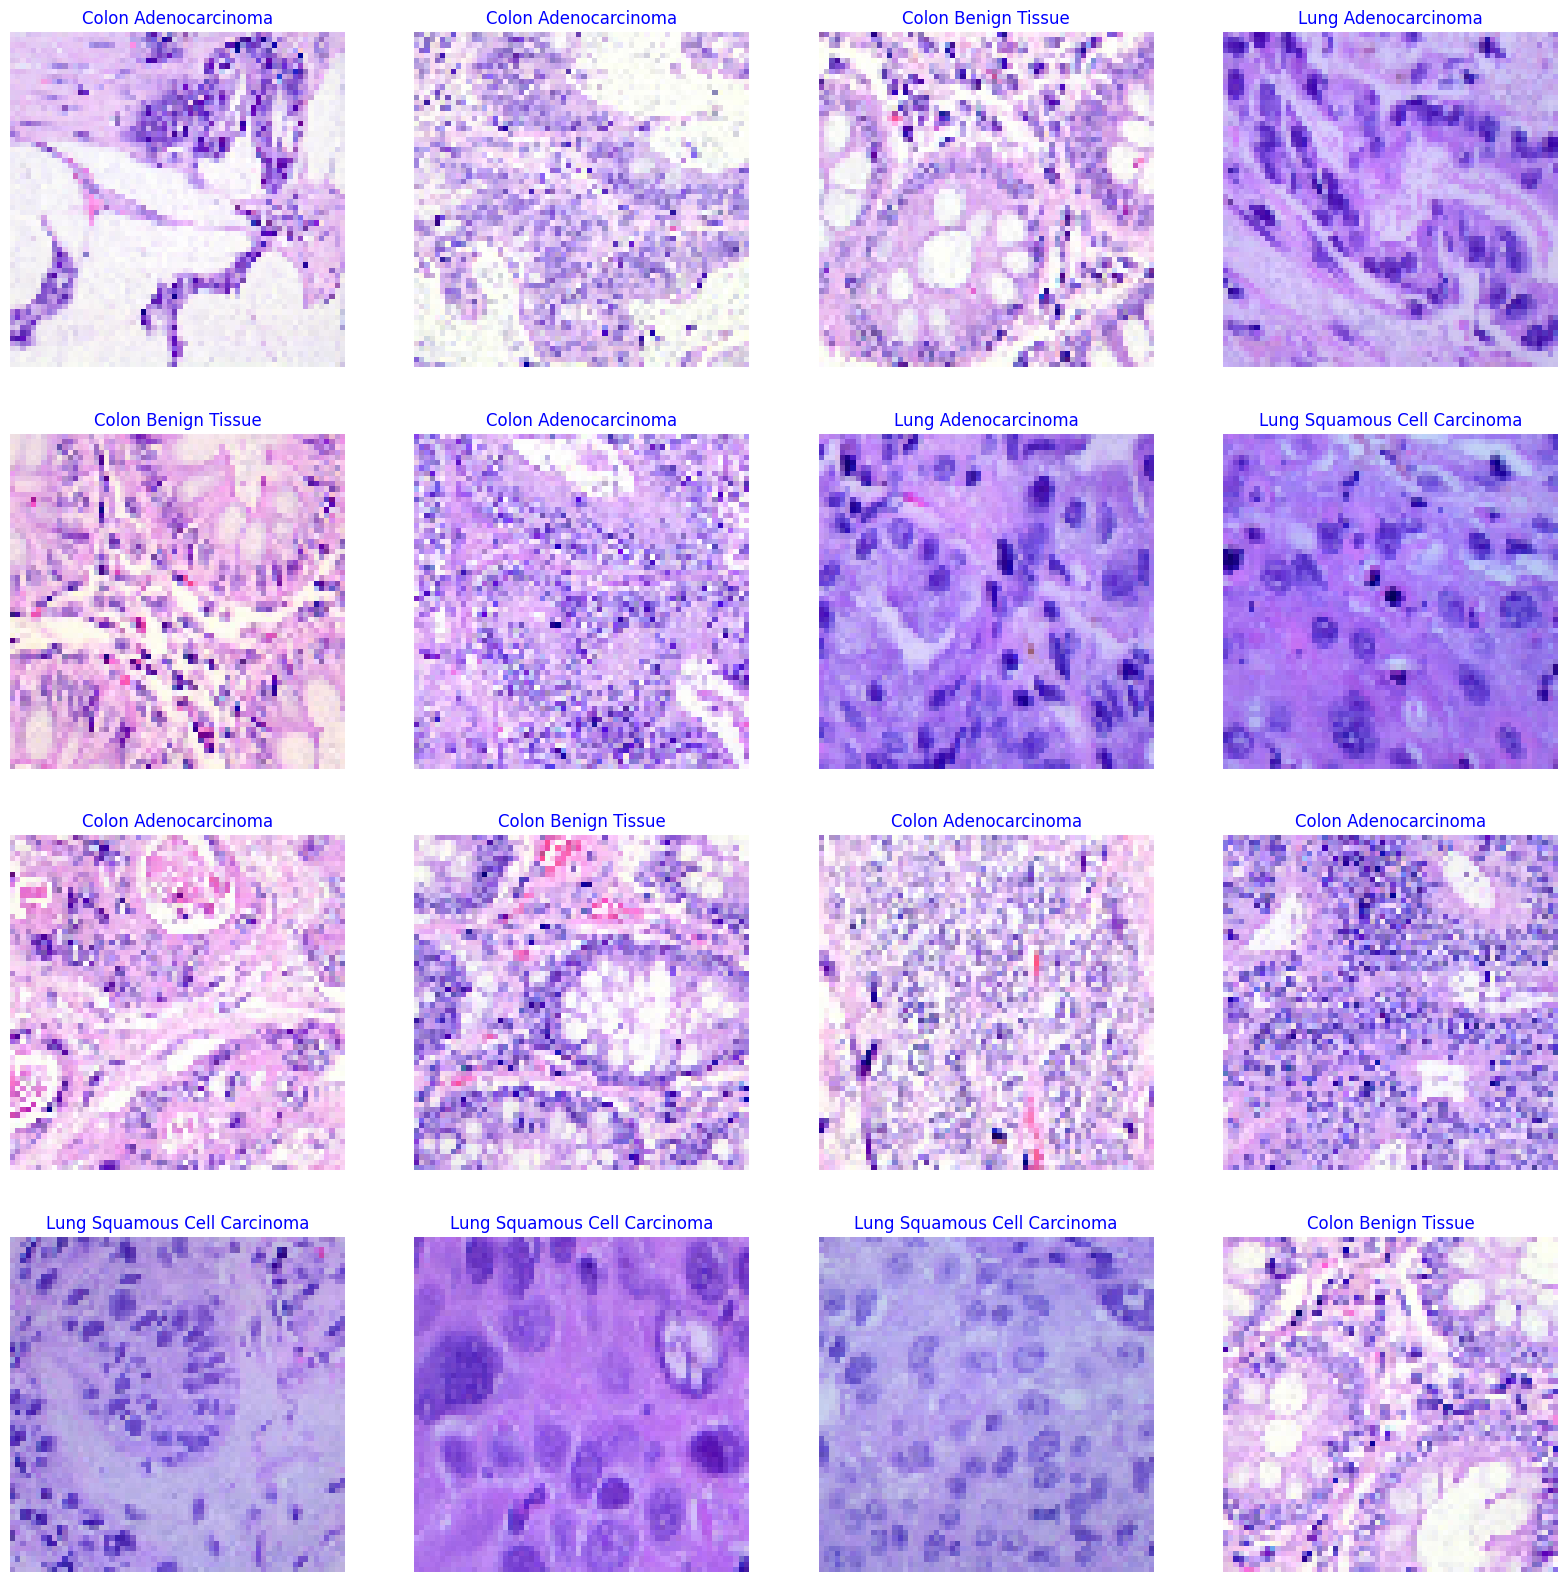

In [ ]:
g_dict =train_gen.class_indices
classes= list(g_dict)
images, labels = next(train_gen)
plt.figure(figsize=(20,20))
for i in range (16) :
        plt.subplot(4,4,i+1)
        image = images[i] /255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name , color = "blue", fontsize =12 )
        plt.axis("off")
plt.show()

In [ ]:
'''
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    # Layer 1: 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 2: 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation

    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 3: Max pooling layer with a 2x2 pooling window and stride of 2 (reduces spatial dimensions by half)


    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 4: 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 5: 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation

    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 6: Max pooling layer with a 2x2 pooling window and stride of 2

    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 7: 256 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 8: 256 filters, a 3x3 kernel, 'same' padding, and ReLU activation

    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 9: Max pooling layer with a 2x2 pooling window and stride of 2

    Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 10: 512 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 11: 512 filters, a 3x3 kernel, 'same' padding, and ReLU activation

    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 12: Max pooling layer with a 2x2 pooling window and stride of 2

    Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 13: 512 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 14: 512 filters, a 3x3 kernel, 'same' padding, and ReLU activation

    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 15: Max pooling layer with a 2x2 pooling window and stride of 2

    Flatten(),
    # Layer 16: Flatten layer to convert 2D feature maps to a 1D vector
    Dense(256, activation='relu'),
    # Layer 17: Fully connected dense layer with 256 units and ReLU activation
    Dense(64, activation='relu'),
    # Layer 18: Fully connected dense layer with 64 units and ReLU activation
    Dense(5, activation='softmax')
    # Layer 19: Fully connected dense layer with 5 units and softmax activation (for multi-class classification)
])

model.compile(Adamax(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

epochs = 20
history = model.fit(x=train_gen ,epochs= epochs , verbose= 1, validation_data = valid_gen ,validation_steps =None , shuffle =False)

'''

In [ ]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    # Layer 1: 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 2: 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 3: Max pooling layer with a 2x2 pooling window and stride of 2 (reduces spatial dimensions by half)

    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 4: 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 5: 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 9: Max pooling layer with a 2x2 pooling window and stride of 2

    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 4: 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 5: 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 9: Max pooling layer with a 2x2 pooling window and stride of 2

    Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 10: 512 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    # Layer 11: 512 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # Layer 12: Max pooling layer with a 2x2 pooling window and stride of 2

    Flatten(),
    # Layer 16: Flatten layer to convert 2D feature maps to a 1D vector
    Dense(256, activation='relu'),
    # Layer 17: Fully connected dense layer with 256 units and ReLU activation
    Dense(64, activation='relu'),
    # Layer 18: Fully connected dense layer with 64 units and ReLU activation
    Dense(5, activation='softmax')
    # Layer 19: Fully connected dense layer with 5 units and softmax activation (for multi-class classification)

])

model.compile(Adamax(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
epochs = 20
history = model.fit(x=train_gen ,epochs= epochs , verbose= 1, validation_data = valid_gen ,validation_steps =None , shuffle =False)

Epoch 1/20
313/313 [==============================] - 1875s 6s/step - loss: 0.6502 - accuracy: 0.7243 - val_loss: 0.3838 - val_accuracy: 0.8512
Epoch 2/20
313/313 [==============================] - 1858s 6s/step - loss: 0.3646 - accuracy: 0.8474 - val_loss: 0.3898 - val_accuracy: 0.8272
Epoch 3/20
313/313 [==============================] - 1834s 6s/step - loss: 0.3077 - accuracy: 0.8748 - val_loss: 0.2862 - val_accuracy: 0.8848
Epoch 4/20
313/313 [==============================] - 1809s 6s/step - loss: 0.2432 - accuracy: 0.9050 - val_loss: 0.3302 - val_accuracy: 0.8644
Epoch 5/20
313/313 [==============================] - 1836s 6s/step - loss: 0.2085 - accuracy: 0.9187 - val_loss: 0.2256 - val_accuracy: 0.9092
Epoch 6/20
313/313 [==============================] - 1877s 6s/step - loss: 0.1650 - accuracy: 0.9362 - val_loss: 0.1607 - val_accuracy: 0.9372
Epoch 7/20
313/313 [==============================] - 1874s 6s/step - loss: 0.1358 - accuracy: 0.9480 - val_loss: 0.1339 - val_accuracy:

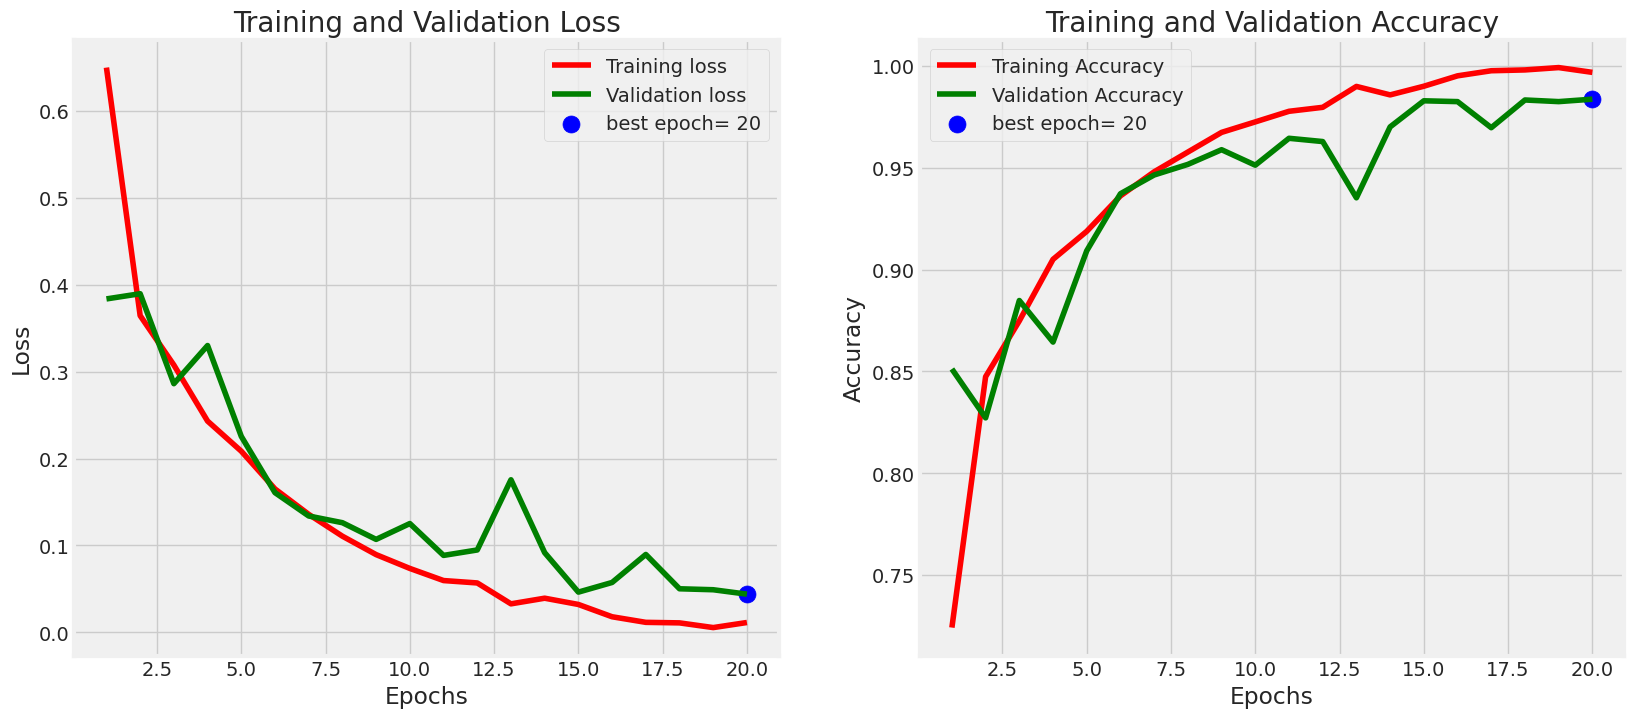

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

40/50 [=======================>......] - ETA: 15s - loss: 0.0439 - accuracy: 0.9836

40/50 [=======================>......] - ETA: 16s - loss: 0.0384 - accuracy: 0.9876

50/50 [==============================] - 66s 1s/step - loss: 0.0384 - accuracy: 0.9876
Train Loss:  0.0032704079058021307
Train Accuracy:  1.0
--------------------
Valid Loss:  0.04386702924966812
Valid Accuracy:  0.9836000204086304
--------------------
Test Loss:  0.03843184560537338
Test Accuracy:  0.9876000285148621


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

<ipython-input-18-9b4dfe328b39>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


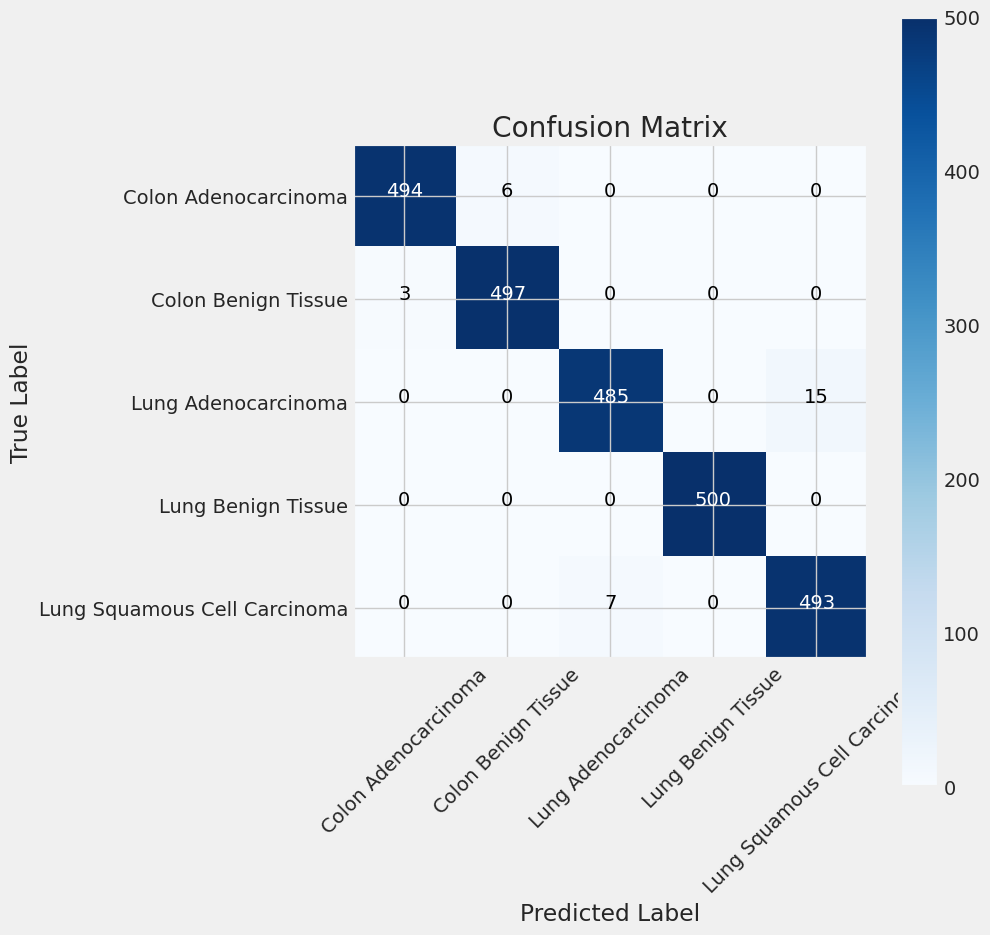

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.99      0.99      0.99       500
         Colon Benign Tissue       0.99      0.99      0.99       500
         Lung Adenocarcinoma       0.99      0.97      0.98       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.97      0.99      0.98       500

                    accuracy                           0.99      2500
                   macro avg       0.99      0.99      0.99      2500
                weighted avg       0.99      0.99      0.99      2500

